### Jupyter notebook for applying/testing this algorithm

Emily Luschen, emily.w.luschen-1@ou.edu  
James Ruppert, jruppert@ou.edu  
5/19/23

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, rc
from precip_class import precip_class
from wrf import getvar, disable_xarray

In [2]:
# Directory/file settings and some parameters

# 3-km WRF output (Typhoon Haiyan)
wrfout = 'wrfout_d02_2013-11-02_12:00:00'

# Output from traditional reflectivity gradient-based classification scheme
pclass_trad = 'pclass_traditional.nc'

# constants
g = 9.8 # [m/s^2]

### Read variables and conduct classification
---

In [3]:
# Read function

def var_read(infile, varname):
    ncfile = Dataset(infile)
    var = ncfile.variables[varname][...]
    ncfile.close()
    var = np.squeeze(var)
    return var

def var_wrfread(infile, varname):
    disable_xarray()
    ncfile = Dataset(infile)
    var = getvar(ncfile, varname)
    ncfile.close()
    var = np.squeeze(var)
    return var

In [4]:
# Read in hydrostatic pressure to get dp for integral
p_hyd = var_read(wrfout,'P_HYD') # Pa
p_hyd = np.ma.masked_where((p_hyd < 100e2), p_hyd, copy=False) # Mask out levels above 100 hPa
nz, nj, ni = p_hyd.shape
dp = np.gradient(p_hyd, axis=0, edge_order=1) # [Pa] Uses second order centered differencing

# Read in and vertically integrate mixing ratios
q_list = ['QCLOUD', 'QRAIN','QICE', 'QSNOW', 'QGRAUP']
nvar = len(q_list)
q_var = []
for ivar in range(nvar):
    # q_var.append(var_read(wrf_file,q_list[ivar]))
    ivar = var_read(wrfout,q_list[ivar]) # kg/kg
    # Mass-weighted integral over full depth; yields kg/m^2 = mm (1/rho_water implicit)
    q_var.append(ivar)

q_var = np.stack(q_var, axis=0)
q_int = np.sum(q_var*dp, axis=1)/(-g)

In [5]:
# Run classification
c_type = precip_class(q_int)
#   0: non-precipitating
# Convective:
#   1: deep convective
#   2: congestus
#   3: shallow
# Layered:
#   4: stratiform
#   5: anvil (weaker rainfall)

In [6]:
# Traditional classification scheme
#   Fortran code to calculate this from same model output courtesy of
#   Rosi Rios-Berrios (NCAR), who wrote it based on Rogers (2010, JAS)
varfil_main = Dataset(pclass_trad)
c_type_og = varfil_main.variables['c_type'][:,:,:,:]
varfil_main.close()
c_type_og = np.squeeze(c_type_og)
#  0: non-precipitating
#  1: convective
#  2: stratiform
#  3: "other" (assumed to be anvil)

### Read additional variables for assessment of classification scheme
---

In [7]:
# Radiative tendencies [K/s]
varname='RTHRATLW'
lw = var_read(wrfout,varname)*3600*24 # K/s --> K/d
varname='RTHRATLWC'
lwc = var_read(wrfout,varname)*3600*24 # K/s --> K/d
varname='RTHRATSW'
sw = var_read(wrfout,varname)*3600*24 # K/s --> K/d
varname='RTHRATSWC'
swc = var_read(wrfout,varname)*3600*24 # K/s --> K/d
crf = sw + lw - lwc - swc

# Vertically integrated radiative terms
lw_t = var_read(wrfout,'LWUPT') - var_read(wrfout,'LWDNT') # W/m2
lw_b = var_read(wrfout,'LWUPB') - var_read(wrfout,'LWDNB') # W/m2
lw_net = lw_b - lw_t
# Clear sky
lw_tc = var_read(wrfout,'LWUPTC') - var_read(wrfout,'LWDNTC') # W/m2
lw_bc = var_read(wrfout,'LWUPBC') - var_read(wrfout,'LWDNBC') # W/m2 = J/m2/s
lw_net_cs = lw_bc - lw_tc
acre = lw_net - lw_net_cs

# Vertical motion [m/s]
varname='wa'
w = var_wrfread(wrfout,varname) # wrf.getvar interpolates onto mass grid

In [8]:
# Dry and moist static energy (DSE, MSE), J/kg

# Various necessary vars
varname='T'
tmpk = var_read(wrfout,varname) # Temperature [K]
varname='geopt'
ph = var_wrfread(wrfout,varname) # Geopotential = g*z; wrf.getvar interpolates onto mass grid
varname='QVAPOR'
qv = var_read(wrfout,varname) # Water vapor mixing ratio [kg/kg]

# ;LATENT HEAT OF VAPORIZATION
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
lv = lv0 - (cpl-cpv)*(tmpk-273.15)

# Dry static energy (DSE)
dse_z = cp*tmpk + ph
dse = np.sum(dse_z*dp, axis=0)/(-g) # Vertically integrated up to 100 hPa

# Moist static energy (MSE)
mse_z = dse_z + lv*qv
mse = np.sum(mse_z*dp, axis=0)/(-g) # Vertically integrated up to 100 hPa

In [9]:
# MSE variance terms

# Remove means
mse_mean = np.mean(mse)
mse_p = mse - mse_mean
lw_mean = np.mean(lw_net)
lw_p = lw_net - lw_mean
lw_mean_cs = np.mean(lw_net_cs)
lw_p_cs = lw_net_cs - lw_mean_cs

# Calculate covariance
lwmse = mse_p*lw_p # J/m2 * J/m2/s = (J/m2)^2 / s
msevar = np.var(mse) # (J/m2)^2
lwmse /= msevar # units = /s
lwmse *= 3600*24 # /s --> /day

# Clear-sky
lwmsec = mse_p*lw_p_cs # J/m2 * J/m2/s = (J/m2)^2 / s
lwmsec /= msevar # units = /s
lwmsec *= 3600*24 # s/day * /s = /day

### Classification-based statistics
---

In [10]:
def area_stats(label, total, npts):
    print('number of '+label+' points: ', total,'; domain fraction: ', 
        np.round(1e2*total/npts, decimals=2), '%')

In [11]:
print('Area fractions of each class:')
print()
print('New classification:')
print()
area_stats('deep convective', np.sum(c_type==1), nj*ni)
area_stats('congestus', np.sum(c_type==2), nj*ni)
area_stats('shallow convective', np.sum(c_type==3), nj*ni)
area_stats('stratiform', np.sum(c_type==4), nj*ni)
area_stats('anvil', np.sum(c_type==5), nj*ni)
area_stats('all-precip', np.sum(c_type > 0), nj*ni)
area_stats('non-raining', np.sum(c_type==0), nj*ni)

Area fractions of each class:

New classification:

number of deep convective points:  12629 ; domain fraction:  1.42 %
number of congestus points:  12144 ; domain fraction:  1.37 %
number of shallow convective points:  34582 ; domain fraction:  3.89 %
number of stratiform points:  54867 ; domain fraction:  6.18 %
number of anvil points:  53112 ; domain fraction:  5.98 %
number of all-precip points:  167334 ; domain fraction:  18.84 %
number of non-raining points:  720666 ; domain fraction:  81.16 %


In [12]:
print('Traditional classification:')
print()
area_stats('convective', np.sum(c_type_og==1), nj*ni)
area_stats('stratiform', np.sum(c_type_og==2), nj*ni)
area_stats('anvil', np.sum(c_type_og==3), nj*ni)
area_stats('all-precip', np.sum(c_type_og > 0), nj*ni)
area_stats('non-raining', np.sum(c_type_og==0), nj*ni)

Traditional classification:

number of convective points:  25066 ; domain fraction:  2.82 %
number of stratiform points:  39599 ; domain fraction:  4.46 %
number of anvil points:  36569 ; domain fraction:  4.12 %
number of all-precip points:  101234 ; domain fraction:  11.4 %
number of non-raining points:  786766 ; domain fraction:  88.6 %


In [13]:
def mse_stats_class(label, ind):
    total = np.sum(lwmse[ind[0],ind[1]])/ind[0].shape[0]*1e2
    print(label+' points: ', np.round(total, decimals=2), 'W/m^2')

In [14]:
# Masked LWMSE terms
print("Sum(LW'MSE') over class normalized by class area")
print()
print('New classification:')
print()
mse_stats_class('deep convective', (c_type==1).nonzero())
mse_stats_class('congestus', (c_type==2).nonzero())
mse_stats_class('shallow convective', (c_type==3).nonzero())
mse_stats_class('stratiform', (c_type==4).nonzero())
mse_stats_class('anvil', (c_type==5).nonzero())
mse_stats_class('all-precip', (c_type > 0).nonzero())
mse_stats_class('non-raining', (c_type==0).nonzero())

Sum(LW'MSE') over class normalized by class area

New classification:

deep convective points:  38.37 W/m^2
congestus points:  0.65 W/m^2
shallow convective points:  5.69 W/m^2
stratiform points:  39.76 W/m^2
anvil points:  29.05 W/m^2
all-precip points:  26.38 W/m^2
non-raining points:  4.44 W/m^2


In [15]:
print('Traditional classification:')
print()
mse_stats_class('convective', (c_type_og==1).nonzero())
mse_stats_class('stratiform', (c_type_og==2).nonzero())
mse_stats_class('anvil', (c_type_og==3).nonzero())
mse_stats_class('all-precip', (c_type_og > 0).nonzero())
mse_stats_class('non-raining', (c_type_og==0).nonzero())

Traditional classification:

convective points:  17.73 W/m^2
stratiform points:  30.99 W/m^2
anvil points:  18.47 W/m^2
all-precip points:  23.18 W/m^2
non-raining points:  6.69 W/m^2


In [16]:
def mse_stats_domain(label, ind, npts):
    total = np.sum(lwmse[ind[0],ind[1]])/npts
    print(label+' points: ', np.round(total, decimals=3), 'W/m^2')

In [17]:
print("Sum(LW'MSE') over class normalized by total domain area")
print()
print('New classification:')
print()
mse_stats_domain('deep convective', (c_type==1).nonzero(), nj*ni)
mse_stats_domain('congestus', (c_type==2).nonzero(), nj*ni)
mse_stats_domain('shallow convective', (c_type==3).nonzero(), nj*ni)
mse_stats_domain('stratiform', (c_type==4).nonzero(), nj*ni)
mse_stats_domain('anvil', (c_type==5).nonzero(), nj*ni)
mse_stats_domain('all-precip', (c_type > 0).nonzero(), nj*ni)
mse_stats_domain('non-raining', (c_type==0).nonzero(), nj*ni)

Sum(LW'MSE') over class normalized by total domain area

New classification:

deep convective points:  0.005 W/m^2
congestus points:  0.0 W/m^2
shallow convective points:  0.002 W/m^2
stratiform points:  0.025 W/m^2
anvil points:  0.017 W/m^2
all-precip points:  0.05 W/m^2
non-raining points:  0.036 W/m^2


In [18]:
print('Traditional classification:')
print()
mse_stats_domain('convective', (c_type_og==1).nonzero(), nj*ni)
mse_stats_domain('stratiform', (c_type_og==2).nonzero(), nj*ni)
mse_stats_domain('anvil', (c_type_og==3).nonzero(), nj*ni)
mse_stats_domain('all-precip', (c_type_og > 0).nonzero(), nj*ni)
mse_stats_domain('non-raining', (c_type_og==0).nonzero(), nj*ni)

Traditional classification:

convective points:  0.005 W/m^2
stratiform points:  0.014 W/m^2
anvil points:  0.008 W/m^2
all-precip points:  0.026 W/m^2
non-raining points:  0.059 W/m^2


## Plot results
---

In [19]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

#### Map of classifications

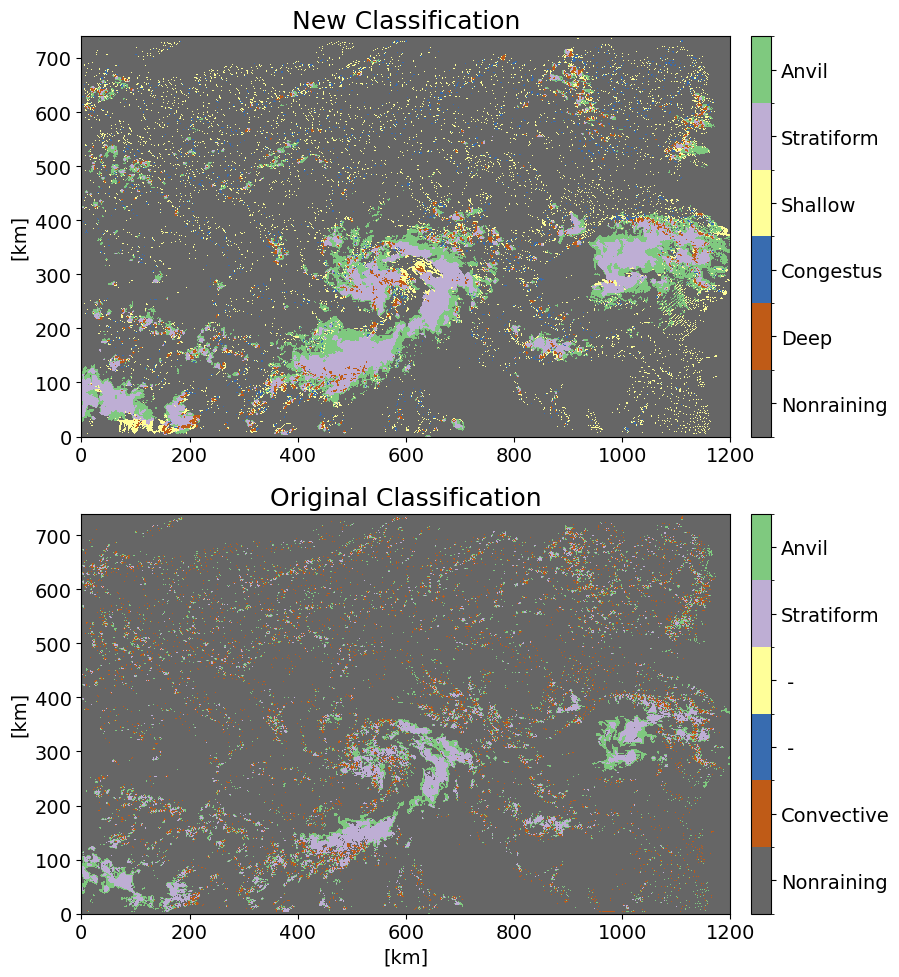

In [20]:
bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)
nlevs = len(bounds) - 1
cmap = plt.get_cmap('Accent_r', nlevs)

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')

ax = fig.add_subplot(211, aspect='equal')
plt.pcolormesh(c_type, cmap=cmap, norm=norm)
cbar=plt.colorbar(fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
cbar.set_ticklabels(['Nonraining','Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil'])
cbar.ax.tick_params(labelsize=14)
ax.set_ylabel('[km]')
ax.set_title("New Classification", size=18)

c_type_og2 = np.copy(c_type_og)
c_type_og2[(c_type_og >= 2)] += 2

ax = fig.add_subplot(212,aspect='equal')
plt.pcolormesh(c_type_og2, cmap=cmap, norm=norm)
cbar=plt.colorbar(fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
cbar.set_ticklabels(['Nonraining','Convective',' - ',' - ','Stratiform','Anvil'])
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel('[km]')
ax.set_ylabel('[km]')
ax.set_title("Original Classification", size=18)
plt.tight_layout()

#### Maps of MSE-LW variance masked by class

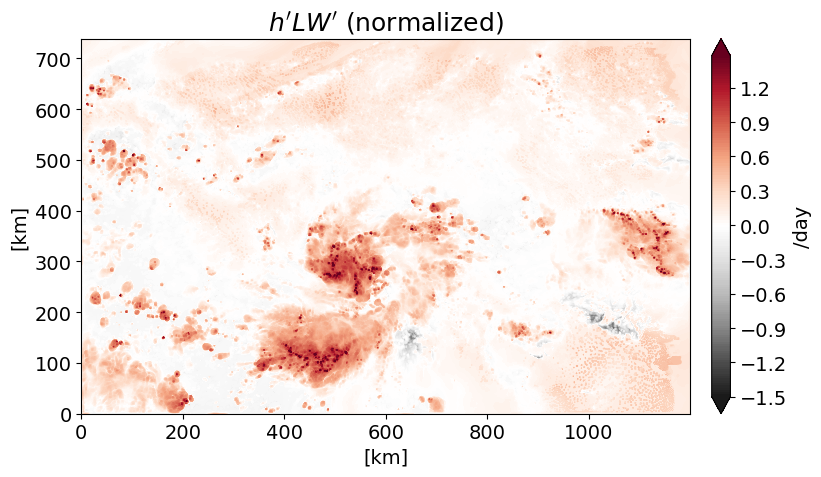

In [21]:
# Unmasked

fig = plt.figure(figsize=(12,5))
fig.set_facecolor('white')

clevs = np.arange(-1.5,1.5,0.02)
ax = fig.add_subplot(111, aspect='equal')
plt.contourf(lwmse, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_xlabel('[km]')
ax.set_ylabel('[km]')
ax.set_title("$h'LW'$ (normalized)", size=18)
plt.tight_layout()

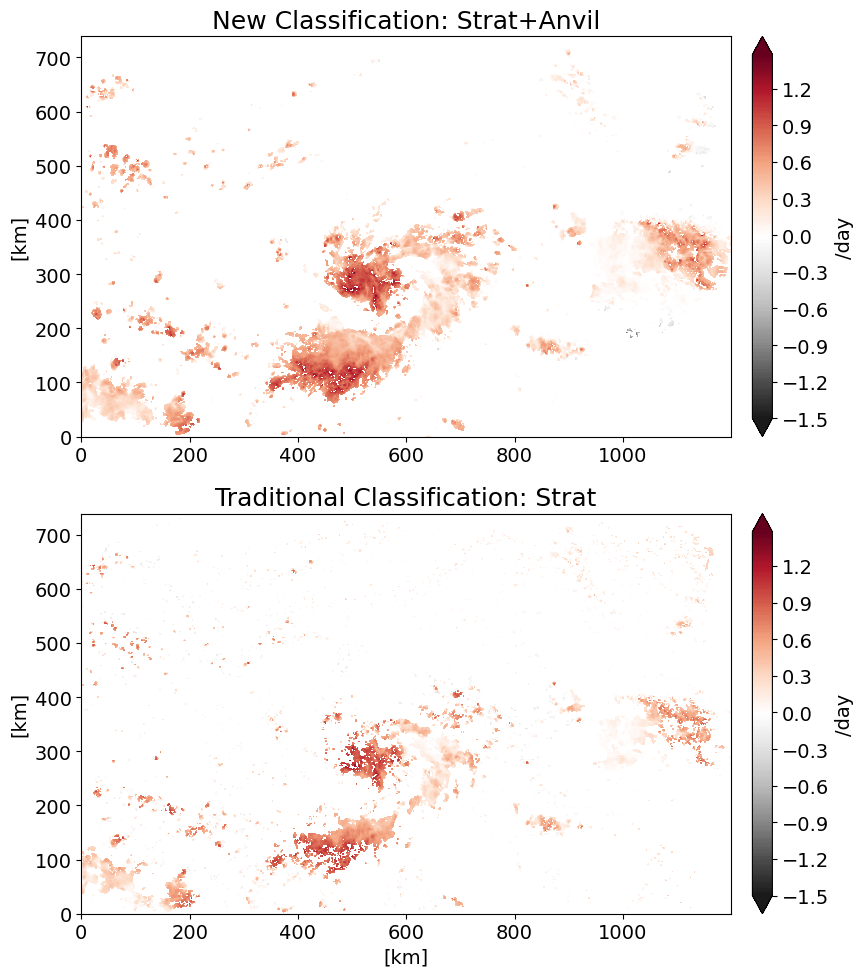

In [22]:
# Stratiform

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')

clevs = np.arange(-1.5,1.5,0.02)

# New classification
lwmse_mask = np.ma.masked_where((c_type < 4), lwmse, copy=True)
ax = fig.add_subplot(211,aspect='equal')
plt.contourf(lwmse_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_ylabel('[km]')
ax.set_title("New Classification: Strat+Anvil", size=18)

# Traditional classification
lwmse_mask = np.ma.masked_where((c_type_og < 2), lwmse, copy=True)
ax = fig.add_subplot(212,aspect='equal')
plt.contourf(lwmse_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_xlabel('[km]')
ax.set_ylabel('[km]')
ax.set_title("Traditional Classification: Strat", size=18)

plt.tight_layout()

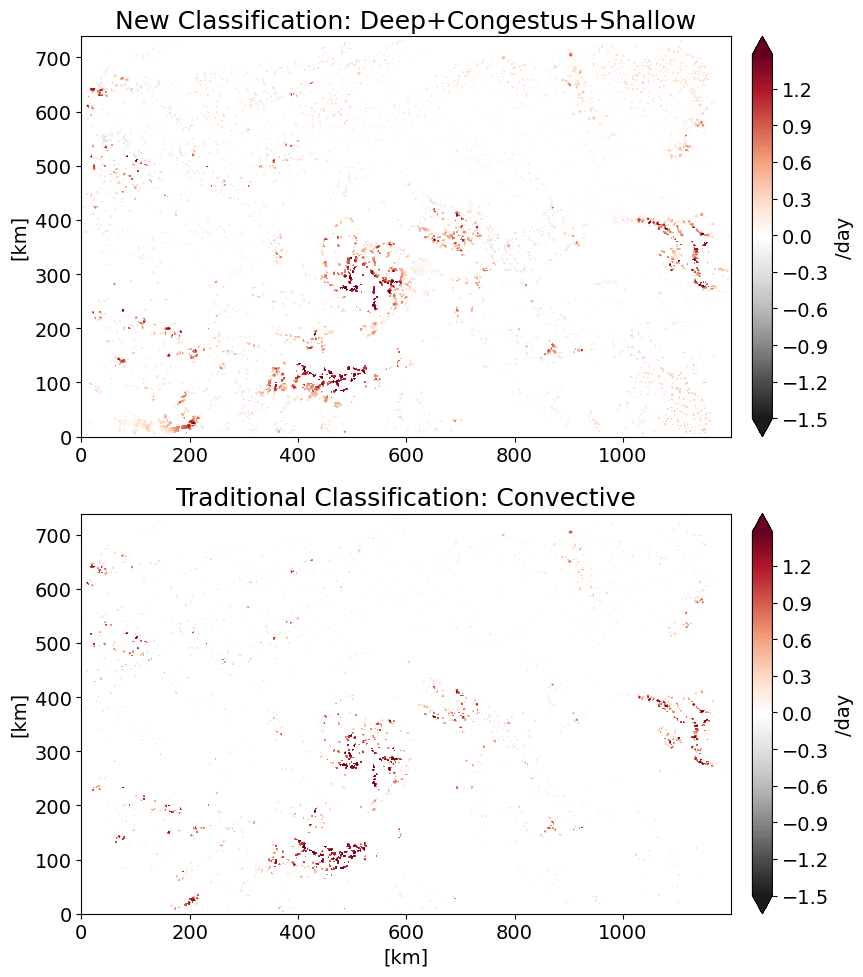

In [23]:
# Convective

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')

clevs = np.arange(-1.5,1.5,0.02)

# New classification
lwmse_mask = np.ma.masked_where(((c_type == 0) | (c_type > 3)), lwmse, copy=True)
ax = fig.add_subplot(211,aspect='equal')
plt.contourf(lwmse_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_ylabel('[km]')
ax.set_title("New Classification: Deep+Congestus+Shallow", size=18)

# Traditional classification
lwmse_mask = np.ma.masked_where((c_type_og != 1), lwmse, copy=True)
ax = fig.add_subplot(212,aspect='equal')
plt.contourf(lwmse_mask, clevs, cmap='RdGy_r', extend='both', zorder=1)
cbar=plt.colorbar(fraction=0.03, pad=0.02)
cbar.set_label('/day')
ax.set_xlabel('[km]')
ax.set_ylabel('[km]')
ax.set_title("Traditional Classification: Convective", size=18)

plt.tight_layout()

#### Average w-profiles

In [24]:
# New classification scheme
precip_list = ['Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
n_class = len(precip_list)
w_profile = np.empty((n_class,nz))
for t in range(n_class):
    ind = (c_type == t+1).nonzero()
    w_profile[t,:] = np.mean(w[:,ind[0],ind[1]], axis=1)

ind = ((c_type > 0) & (c_type < 4)).nonzero()
w_conv = np.mean(w[:,ind[0],ind[1]], axis=1) # convective total
ind = (c_type > 3).nonzero()
w_strat = np.mean(w[:,ind[0],ind[1]], axis=1) # stratiform total

# Traditional classification scheme
precip_list_og = ['conv', 'strat', 'mixed']
n_class_og = len(precip_list)
w_profile_og = np.empty((n_class_og,nz))
for t in range(n_class_og):
    ind = (c_type_og == t+1).nonzero()
    w_profile_og[t,:] = np.mean(w[:,ind[0],ind[1]], axis=1)

/home/jamesrup/miniconda3/envs/plotting/lib/python3.10/site-packages/numpy/ma/core.py:5246: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/jamesrup/miniconda3/envs/plotting/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [25]:
# Use mean p_hyd as vertical coordinate
pres = np.mean(p_hyd, axis=(1,2))*1e-2 # Pa --> hPa

Text(0, 0.5, 'Pressure [hPa]')

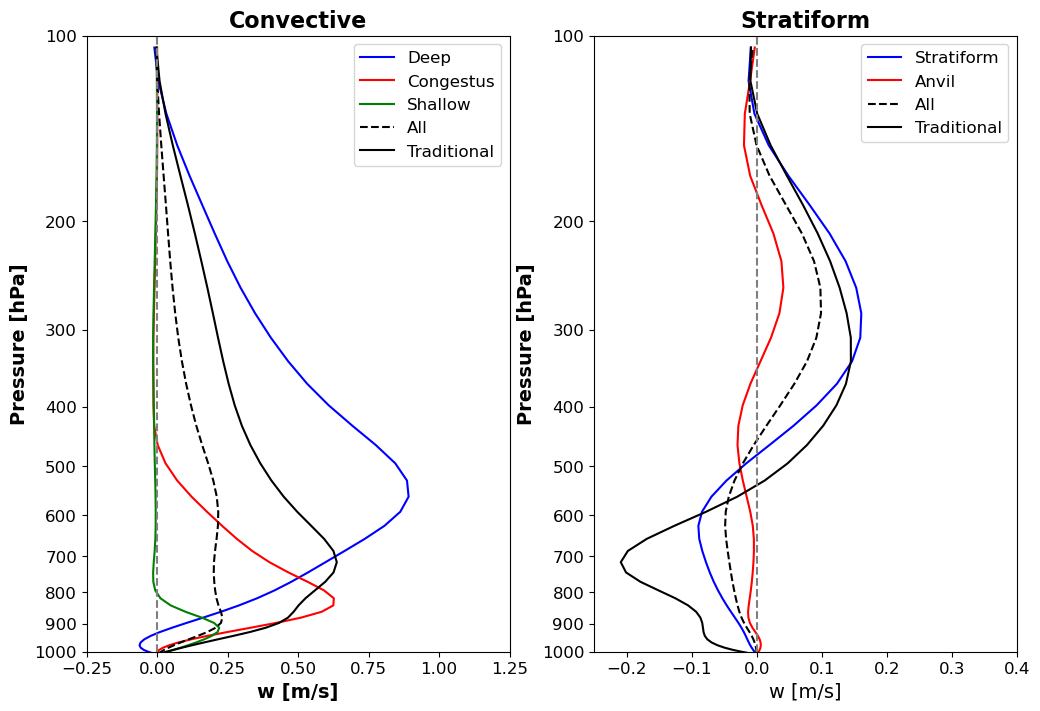

In [26]:
# w profile
fig = plt.figure(figsize=(12,8),facecolor='white')

ax = fig.add_subplot(121)
ax.plot(w_profile[0], pres, label=precip_list[0], color='blue')
ax.plot(w_profile[1], pres, label=precip_list[1], color='red')
ax.plot(w_profile[2], pres, label=precip_list[2], color='green')
ax.plot(w_conv, pres, label='All', linestyle='--', color='black')
ax.plot(w_profile_og[0], pres, label='Traditional', color='black')
ax.set_title('Convective', size=16, weight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)
plt.xlim(-0.25,1.25)
plt.xticks(size=12)
plt.xlabel('w [m/s]', size=14, weight='bold')
plt.ylabel('Pressure [hPa]', size=14, weight='bold')

ax = fig.add_subplot(122)
ax.plot(w_profile[3], pres, label=precip_list[3], color='blue')
ax.plot(w_profile[4], pres, label=precip_list[4], color='red')
ax.plot(w_strat, pres, label='All', linestyle='--', color='black')
ax.plot(w_profile_og[1], pres, label='Traditional', color='black')
ax.set_title('Stratiform', size=16, weight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
plt.ylim(1000,100)
plt.xlim(-0.25,0.4)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)
plt.xticks(size=12)
plt.xlabel('w [m/s]', size=14)
plt.ylabel('Pressure [hPa]', size=14, weight='bold')

#### Avg cloud–radiation forcing profiles

In [27]:
# New classification scheme
crf_profile = np.empty((n_class,nz))
for t in range(n_class):
    ind = (c_type == t+1).nonzero()
    crf_profile[t,:] = np.mean(crf[:,ind[0],ind[1]], axis=1)

ind = ((c_type > 0) & (c_type < 4)).nonzero()
crf_conv = np.mean(crf[:,ind[0],ind[1]], axis=1) # convective total
ind = (c_type > 3).nonzero()
crf_strat = np.mean(crf[:,ind[0],ind[1]], axis=1) # stratiform total

# Traditional classification scheme
crf_profile_og = np.empty((n_class_og,nz))
for t in range(n_class_og):
    ind = (c_type_og == t+1).nonzero()
    crf_profile_og[t,:] = np.mean(crf[:,ind[0],ind[1]], axis=1)

Text(0, 0.5, 'Pressure [hPa]')

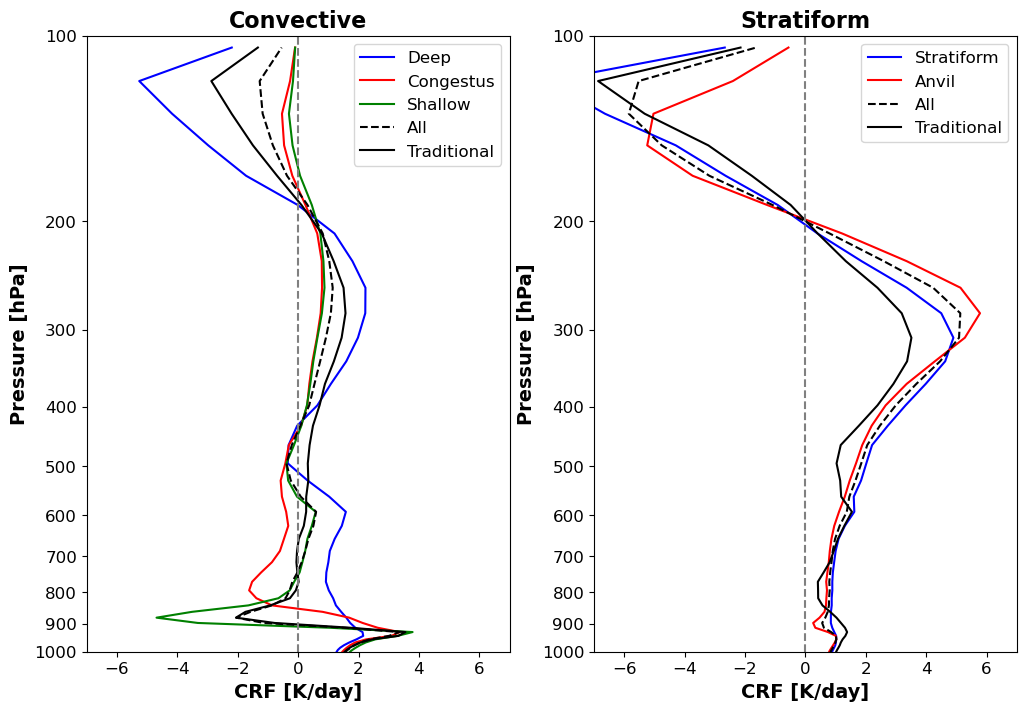

In [28]:
# CRF profile
fig = plt.figure(figsize=(12,8),facecolor='white')

ax = fig.add_subplot(121)
ax.plot(crf_profile[0], pres, label=precip_list[0], color='blue')
ax.plot(crf_profile[1], pres, label=precip_list[1], color='red')
ax.plot(crf_profile[2], pres, label=precip_list[2], color='green')
ax.plot(crf_conv, pres, label='All', linestyle='--', color='black')
ax.plot(crf_profile_og[0], pres, label='Traditional', color='black')
ax.set_title('Convective', size=16, weight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)
plt.xlim(-7,7)
plt.xticks(size=12)
plt.xlabel('CRF [K/day]', size=14, weight='bold')
plt.ylabel('Pressure [hPa]', size=14, weight='bold')

ax = fig.add_subplot(122)
ax.plot(crf_profile[3], pres, label=precip_list[3], color='blue')
ax.plot(crf_profile[4], pres, label=precip_list[4], color='red')
ax.plot(crf_strat, pres, label='All', linestyle='--', color='black')
ax.plot(crf_profile_og[1], pres, label='Traditional', color='black')
ax.set_title('Stratiform', size=16, weight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
plt.ylim(1000,100)
plt.xlim(-7,7)
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)
plt.xticks(size=12)
plt.xlabel('CRF [K/day]', size=14, weight='bold')
plt.ylabel('Pressure [hPa]', size=14, weight='bold')

#### Avg cloud–radiation forcing profiles

In [29]:
# New classification scheme
qice = q_var[0]+q_var[1] # [kg/kg]; cloud + rain
qliq = q_var[2]+q_var[3]+q_var[4] # [kg/kg]; ice + snow + graupel
qtot = qliq+qice
qtot*=1e3
q_profile = np.empty((n_class,nz))
for t in range(n_class):
    ind = (c_type == t+1).nonzero()
    q_profile[t,:] = np.mean(qtot[:,ind[0],ind[1]], axis=1)

ind = ((c_type > 0) & (c_type < 4)).nonzero()
q_conv = np.mean(qtot[:,ind[0],ind[1]], axis=1) # convective total
ind = (c_type > 3).nonzero()
q_strat = np.mean(qtot[:,ind[0],ind[1]], axis=1) # stratiform total

# Traditional classification scheme
q_profile_og = np.empty((n_class_og,nz))
for t in range(n_class_og):
    ind = (c_type_og == t+1).nonzero()
    q_profile_og[t,:] = np.mean(qtot[:,ind[0],ind[1]], axis=1)

Text(0, 0.5, 'Pressure [hPa]')

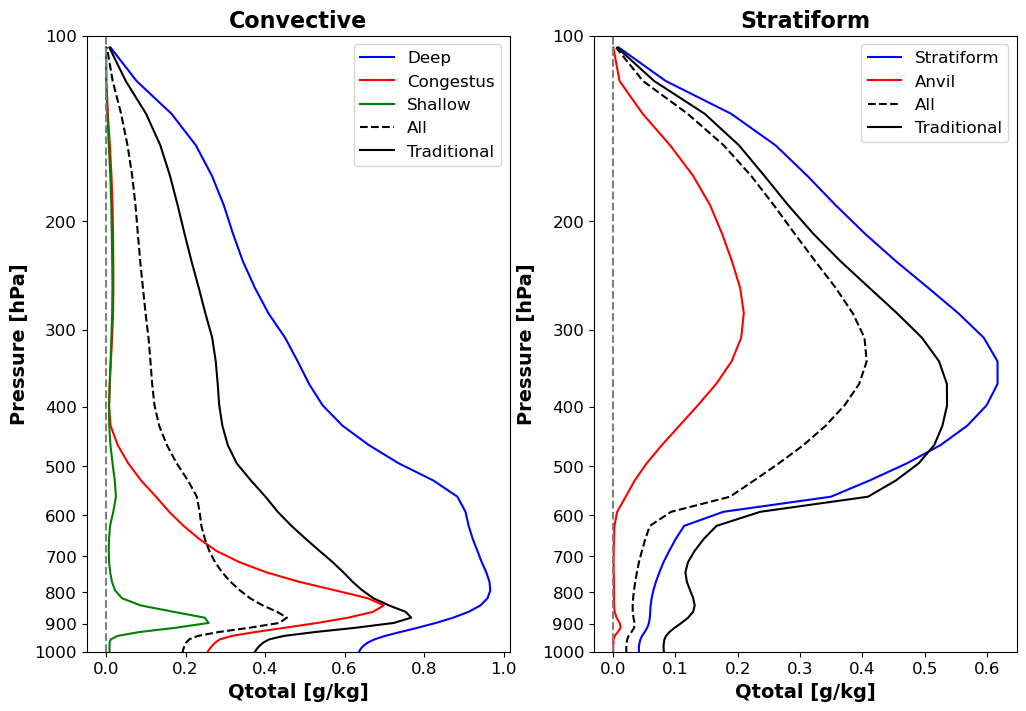

In [30]:
# QTOTAL profile
fig = plt.figure(figsize=(12,8),facecolor='white')

ax = fig.add_subplot(121)
ax.plot(q_profile[0], pres, label=precip_list[0], color='blue')
ax.plot(q_profile[1], pres, label=precip_list[1], color='red')
ax.plot(q_profile[2], pres, label=precip_list[2], color='green')
ax.plot(q_conv, pres, label='All', linestyle='--', color='black')
ax.plot(q_profile_og[0], pres, label='Traditional', color='black')
ax.set_title('Convective', size=16, weight='bold')
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)
plt.xticks(size=12)
plt.xlabel('Qtotal [g/kg]', size=14, weight='bold')
plt.ylabel('Pressure [hPa]', size=14, weight='bold')

ax = fig.add_subplot(122)
ax.plot(q_profile[3], pres, label=precip_list[3], color='blue')
ax.plot(q_profile[4], pres, label=precip_list[4], color='red')
ax.plot(q_strat, pres, label='All', linestyle='--', color='black')
ax.plot(q_profile_og[1], pres, label='Traditional', color='black')
ax.set_title('Stratiform', size=16, weight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.legend(loc='upper right', fontsize=12)
plt.gca().invert_yaxis()
ax.axvline(0, color='gray', linestyle='--')
plt.ylim(1000,100)
ytick_loc=np.arange(1000,0,-100)
plt.yticks(ticks=ytick_loc, size=12)
plt.ylim(1000, 100)
plt.xticks(size=12)
plt.xlabel('Qtotal [g/kg]', size=14, weight='bold')
plt.ylabel('Pressure [hPa]', size=14, weight='bold')